<a href="https://colab.research.google.com/github/PeterPirog/tensorflow-deep-learning/blob/main/NARX_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# https://sysidentpy.org/

!pip install sysidentpy
!pip install matplotlib==3.1.3

     |████████████████████████████████| 42.8 MB 1.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
     |████████████████████████████████| 11.2 MB 40.1 MB/s 
     |████████████████████████████████| 895 kB 51.8 MB/s 
  Created wheel for sysidentpy: filename=sysidentpy-0.1.8-py3-none-any.whl size=101361 sha256=a15ddae0188afd5e370d977759c37b2d245f27a0b95bc1678cf0bfd2685eac35
  Stored in directory: /root/.cache/pip/wheels/32/12/ef/178adaf032939fe1d97ea1ef0b4530643467a49e6c5137baa5
Successfully built sysidentpy
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following de

     |████████████████████████████████| 13.1 MB 6.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sysidentpy 0.1.8 requires matplotlib>=3.3.2, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data


# Generate a dataset of a simulated dynamical system
x_train, x_valid, y_train, y_valid = get_siso_data(
        n=1000,
        colored_noise=False,
sigma=0.001,
train_percentage=80
)

In [4]:
print(np.shape(x_train))

(800, 1)


In [5]:
# Polynomial NARX
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from sysidentpy.metrics._regression import root_relative_squared_error

basis_function = Polynomial(degree=3)
model = FROLS(
        order_selection=True,
        n_info_values=10,
        extended_least_squares=False,
        ylag=2,
        xlag=2,
        info_criteria='aic',
        estimator='least_squares',
        basis_function=basis_function
)
model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)
r = pd.DataFrame(
        results(
                model.final_model, model.theta, model.err,
                model.n_terms, err_precision=8, dtype='sci'
                ),
        columns=['Regressors', 'Parameters', 'ERR'])
print(r)

0.0019438276180262775
             Regressors   Parameters             ERR
0               x1(k-2)   8.9980E-01  9.55476217E-01
1                y(k-1)   1.9990E-01  4.12788889E-02
2         x1(k-1)y(k-1)   9.9927E-02  3.24181620E-03
3      x1(k-2)x1(k-1)^2   3.9665E-04  1.36743449E-08
4  x1(k-2)x1(k-1)y(k-2)  -3.5102E-04  1.14337418E-08
5   x1(k-1)y(k-2)y(k-1)   3.5110E-04  1.07068526E-08
6        y(k-2)^2y(k-1)   3.4476E-04  8.82626743E-09


In [6]:
#!python -m pip uninstall matplotlib
#!pip install matplotlib==3.1.3

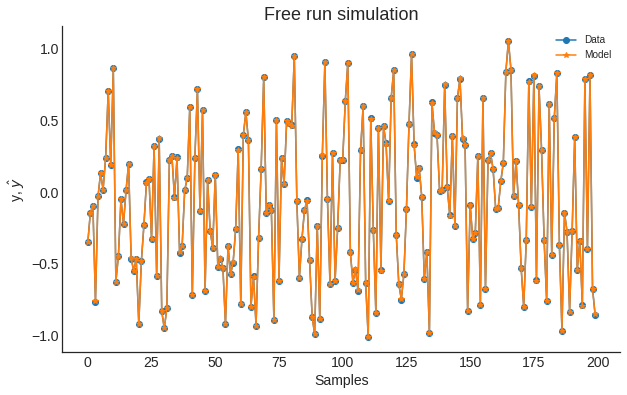

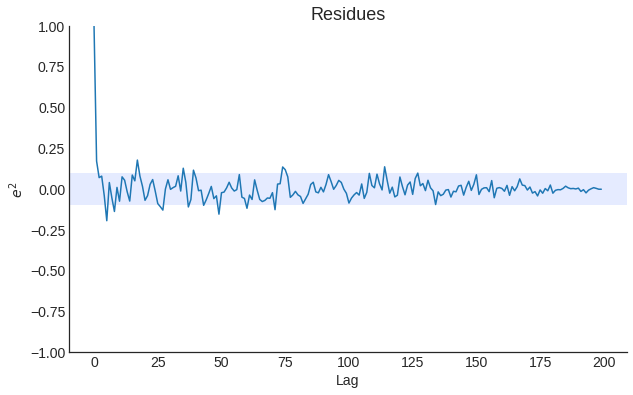

In [7]:
plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
#x1e = compute_cross_correlation(y_valid, yhat, x2_val)
#plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

/usr/local/lib/python3.7/dist-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Function __init__ has been deprecated since v0.1.7.
 Use NARXNN(ylag=2, xlag=2, basis_function='Some basis function') instead.This module was deprecated in favor of NARXNN(ylag=2, xlag=2, basis_function='Some basis function') module into which all the refactored classes and functions are moved.
 This feature will be removed in version v0.2.0.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Function residuals has been deprecated since v0.1.7.
 Use from sysidentpy.residues_correlation import compute_cross_correlation, compute_residues_autocorrelation instead.This module was deprecated in favor of from sysidentpy.residues_correlation import compute_cross_correlation, compute_residues_autocorrelation module into which all the refactored classes and functions are moved.
 This feature will be removed in version v0.2.0.
  w

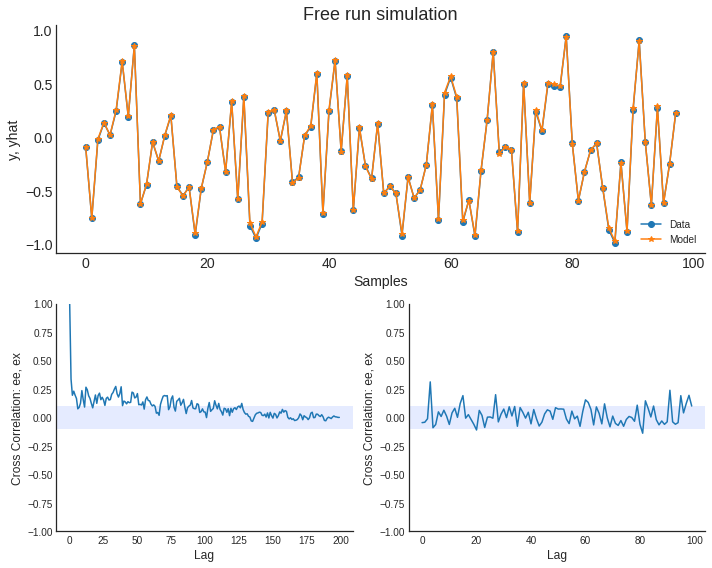

In [8]:
from torch import nn
from sysidentpy.neural_network import NARXNN

class NARX(nn.Module):
        def __init__(self):
                super().__init__()
                self.lin = nn.Linear(4, 10)
                self.lin2 = nn.Linear(10, 10)
                self.lin3 = nn.Linear(10, 1)
                self.tanh = nn.Tanh()

        def forward(self, xb):
                z = self.lin(xb)
                z = self.tanh(z)
                z = self.lin2(z)
                z = self.tanh(z)
                z = self.lin3(z)
                return z

narx_net = NARXNN(
        net=NARX(),
        ylag=2,
        xlag=2,
        loss_func='mse_loss',
        optimizer='Adam',
        epochs=200,
        verbose=False,
        optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
)

train_dl = narx_net.data_transform(x_train, y_train)
valid_dl = narx_net.data_transform(x_valid, y_valid)
narx_net.fit(train_dl, valid_dl)
yhat = narx_net.predict(x_valid, y_valid)
ee, ex, extras, lam = narx_net.residuals(x_valid, y_valid, yhat)
narx_net.plot_result(y_valid, yhat, ee, ex)